# [Introduction to `statsmodels`](https://www.datacamp.com/completed/statement-of-accomplishment/course/f12f6c4114c7fde2599ee7200de0a56aeb2251ad)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/data_science/introduction_to_statsmodels/notebook.ipynb)

**Contents**
- [Linear Regression](#Linear-Regression)
- [Predictions](#Predictions)
- [Assessing Fit](#Assessing-Fit)
- [Logistic Regression](#Logistic-Regression)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.api import qqplot
from statsmodels.formula.api import logit, ols
from statsmodels.graphics.mosaicplot import mosaic

BASE_URL = "https://raw.githubusercontent.com/adamelliotfields/datacamp/main/notebooks/data_science/introduction_to_statsmodels/"

ad_conversion = pd.read_csv(BASE_URL + "ad_conversion.csv")
churn = pd.read_csv(BASE_URL + "churn.csv")
sp500_yearly_returns = pd.read_csv(BASE_URL + "sp500_yearly_returns.csv")
taiwan_real_estate = pd.read_csv(BASE_URL + "taiwan_real_estate.csv")

## Linear Regression

_Regression_ is a technique for predicting the values of a response variable from known values of explanatory variables.

In _linear_ regression, the response variable is numeric. A good example is predicting the price of a house from its size. The response variable is the price, and the explanatory variable is the size. Linear regression tries to fit a straight line through the data points.

Note that "response variable", "dependent variable", "output variable", and "target variable" are all synonymous: they refer to the variable that you are trying to predict. This course uses "response variable", but in the context of machine learning you will often hear "target variable".

Likewise, "explanatory variable", "independent variable", "input variable", and "feature" are all synonymous: they refer to the variables that you are using to predict the response variable. This course uses "explanatory variable", but in the context of machine learning you will often hear "feature".

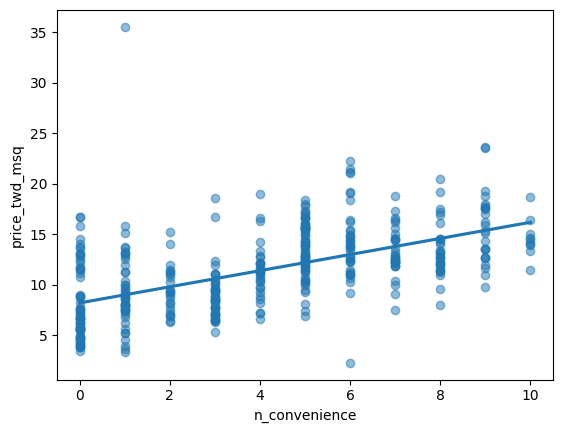

In [2]:
# regression plot `n_convenience` vs `price_twd_msq`
sns.regplot(
    taiwan_real_estate, x="n_convenience", y="price_twd_msq", scatter_kws={"alpha": 0.5}, ci=None
)
plt.show()

### Slope and Intercept

The _slope_ of a regression line is the amount by which the response variable changes when the explanatory variable increases by one unit. Since `n_convenience` is `0.79`, the price per square meter increases by 0.79 Taiwan dollars for every convenience store nearby.

The _intercept_ is the value of the response variable when the explanatory variable is 0. With an intercept of `8.22`, the price is 8.22 per square meter when there are no convenience stores nearby.

In [3]:
# model `price_twd_msq` as a function of `n_convenience`
mdl_price_vs_conv = ols("price_twd_msq ~ n_convenience", data=taiwan_real_estate)

# fit the model
mdl_price_vs_conv = mdl_price_vs_conv.fit()

# print parameters of fitted model
print(mdl_price_vs_conv.params)

Intercept        8.224237
n_convenience    0.798080
dtype: float64


### Categorical Explanatory Variables

If the explanatory variable is categorical, using a scatter plot to visualize the data doesn't make sense. A better option is to use a histogram to visualize the distribution of the response variable for each category.

When modeling categorical data it can be useful to remove the intercept. By default, the intercept is the mean of the response variable for the reference category (e.g., `house_age_years == '0 to 15'`) and the coefficients are the differences. By removing the intercept (no reference category), the coefficients become the means of the response variable for each category.


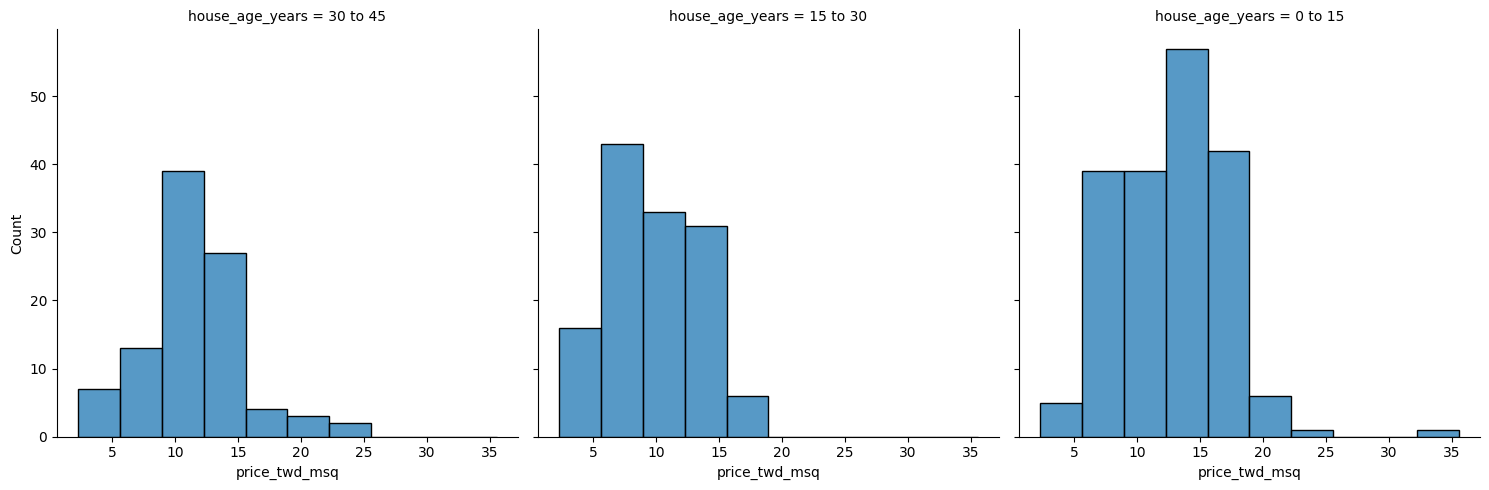

In [4]:
# plot distribution of `price_twd_msq` with 10 bins split by the `house_age_years` category
sns.displot(taiwan_real_estate, x="price_twd_msq", bins=10, col="house_age_years", col_wrap=3)
plt.show()

In [5]:
# mean of `price_twd_msq` for each `house_age_years` category
mean_price_by_age = taiwan_real_estate.groupby("house_age_years").price_twd_msq.mean()
print(mean_price_by_age)

# model `price_twd_msq` as a function of `house_age_years` and fit
mdl_price_vs_age = ols("price_twd_msq ~ house_age_years", data=taiwan_real_estate).fit()
print(mdl_price_vs_age.params)

# update the model to remove the intercept
mdl_price_vs_age = ols("price_twd_msq ~ house_age_years + 0", data=taiwan_real_estate).fit()
print(mdl_price_vs_age.params)

house_age_years
0 to 15     12.637471
15 to 30     9.876743
30 to 45    11.393264
Name: price_twd_msq, dtype: float64
Intercept                      12.637471
house_age_years[T.15 to 30]    -2.760728
house_age_years[T.30 to 45]    -1.244207
dtype: float64
house_age_years[0 to 15]     12.637471
house_age_years[15 to 30]     9.876743
house_age_years[30 to 45]    11.393264
dtype: float64


## Predictions

Statistical models like linear regression allow you make predictions by plugging-in values for the explanatory variables. In machine learning this is known as _inferencing_.

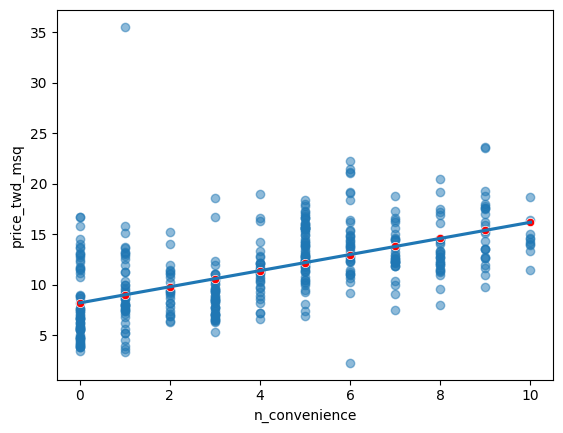

In [6]:
# create explanatory_data DataFrame
explanatory_data = pd.DataFrame({"n_convenience": np.arange(0, 11)})

# predict
prediction_data = explanatory_data.assign(
    price_twd_msq=mdl_price_vs_conv.predict(explanatory_data)
)

# plot predictions
fig = plt.figure()
sns.regplot(
    taiwan_real_estate, x="n_convenience", y="price_twd_msq", scatter_kws={"alpha": 0.5}, ci=None
)
sns.scatterplot(prediction_data, x="n_convenience", y="price_twd_msq", color="red")
plt.show()

### Manual Predictions

For a simple linear regression model, the predicted value is the intercept plus the slope times the explanatory variable: $\hat{y} = \beta_0 + \beta_1 x$.

You might be more familiar with the form $Y = mX + b$.

In [7]:
# get the coefficients
coeffs = mdl_price_vs_conv.params
intercept = coeffs.iloc[0]
slope = coeffs.iloc[1]

# predict
explanatory_data = pd.DataFrame({"n_convenience": np.arange(0, 10)})
price_twd_msq = intercept + slope * explanatory_data

# compare results
price_twd_msq.assign(predictions_auto=mdl_price_vs_conv.predict(explanatory_data))
print(price_twd_msq)

   n_convenience
0       8.224237
1       9.022317
2       9.820397
3      10.618477
4      11.416556
5      12.214636
6      13.012716
7      13.810795
8      14.608875
9      15.406955


### Regression to the Mean

_Regression to the mean_ is a phenomenon where extreme values tend to be followed by more moderate values. It is a common statistical artifact that doesn't necessarily have a causal explanation. In other words, the extreme values are not caused by their preceding values, but rather by luck (chance), and luck tends to run out.

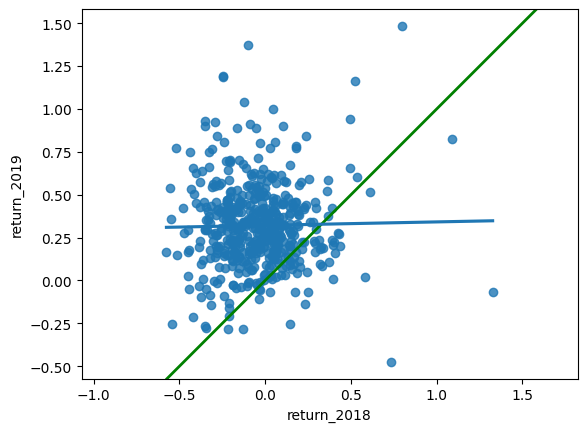

In [8]:
fig = plt.figure()

# plot y=x
plt.axline(xy1=(0, 0), slope=1, linewidth=2, color="green")

# regression plot `return_2019` vs `return_2018`
sns.regplot(sp500_yearly_returns, x="return_2018", y="return_2019", ci=None)

# set the axes limits to be the same
plt.axis("equal")
plt.show()

In [9]:
# model `return_2019` as a function of `return_2018`
mdl_returns = ols("return_2019 ~ return_2018", data=sp500_yearly_returns).fit()

# predict
explanatory_data = pd.DataFrame({"return_2018": [-1, 0, 1]})
print(mdl_returns.predict(explanatory_data))

0    0.301251
1    0.321321
2    0.341390
dtype: float64


### Transforming Variables

If the relationship between the response variable and the explanatory variable is not linear, you may need to transform one or both of them. In machine learning, this is called _feature engineering_.

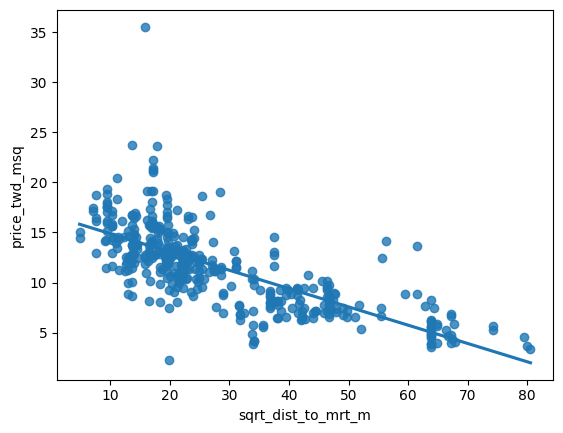

In [10]:
# create `sqrt_dist_to_mrt_m`
taiwan_real_estate["sqrt_dist_to_mrt_m"] = np.sqrt(taiwan_real_estate.dist_to_mrt_m)

# plot
plt.figure()
sns.regplot(taiwan_real_estate, x="sqrt_dist_to_mrt_m", y="price_twd_msq", ci=None)
plt.show()

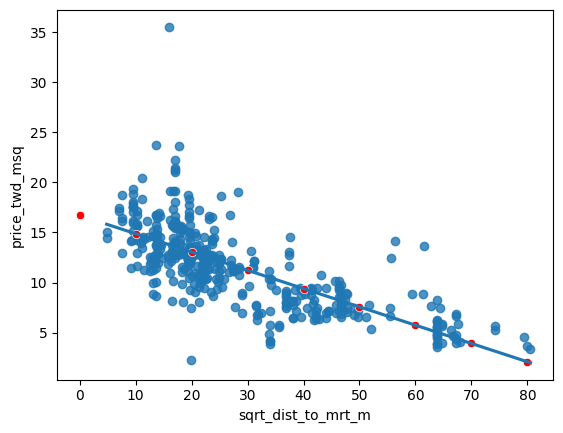

In [11]:
# model `price_twd_msq` as a function of `sqrt_dist_to_mrt_m`
mdl_price_vs_dist = ols("price_twd_msq ~ sqrt_dist_to_mrt_m", data=taiwan_real_estate).fit()

# predict
explanatory_data = pd.DataFrame(
    {
        "sqrt_dist_to_mrt_m": np.sqrt(np.arange(0, 81, 10) ** 2),
        "dist_to_mrt_m": np.arange(0, 81, 10) ** 2,
    }
)
prediction_data = explanatory_data.assign(
    price_twd_msq=mdl_price_vs_dist.predict(explanatory_data)
)

# plot
fig = plt.figure()
sns.regplot(taiwan_real_estate, x="sqrt_dist_to_mrt_m", y="price_twd_msq", ci=None)
sns.scatterplot(prediction_data, x="sqrt_dist_to_mrt_m", y="price_twd_msq", color="red")
plt.show()

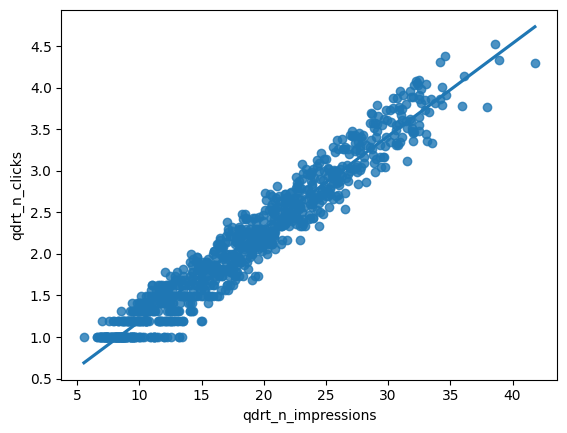

In [12]:
# raise to 0.25
ad_conversion["qdrt_n_impressions"] = ad_conversion.n_impressions**0.25
ad_conversion["qdrt_n_clicks"] = ad_conversion.n_clicks**0.25

# plot
sns.regplot(ad_conversion, x="qdrt_n_impressions", y="qdrt_n_clicks", ci=None)
plt.show()

In [13]:
# model `qdrt_n_clicks` as a function of `qdrt_n_impressions`
mdl_click_vs_impression = ols("qdrt_n_clicks ~ qdrt_n_impressions", data=ad_conversion).fit()

# predict
explanatory_data = pd.DataFrame(
    {
        "qdrt_n_impressions": np.arange(0, 3e6 + 1, 5e5) ** 0.25,
        "n_impressions": np.arange(0, 3e6 + 1, 5e5),
    }
)
prediction_data = explanatory_data.assign(
    qdrt_n_clicks=mdl_click_vs_impression.predict(explanatory_data)
)
print(prediction_data)

   qdrt_n_impressions  n_impressions  qdrt_n_clicks
0            0.000000            0.0       0.071748
1           26.591479       500000.0       3.037576
2           31.622777      1000000.0       3.598732
3           34.996355      1500000.0       3.974998
4           37.606031      2000000.0       4.266063
5           39.763536      2500000.0       4.506696
6           41.617915      3000000.0       4.713520


#### Back Transformations

In order to correctly interpret and visualize your predictions, you need to _back transform_ them by reversing the transformations you made to the variables prior to prediction.

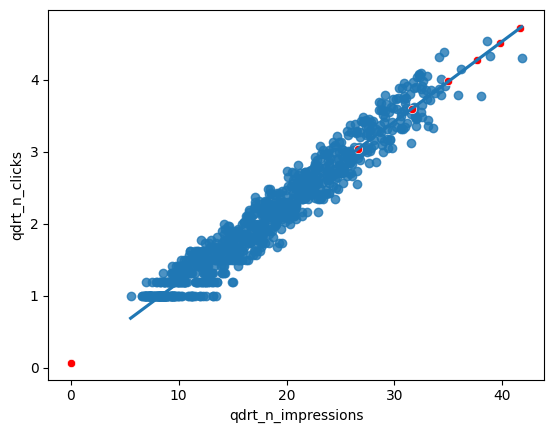

In [14]:
# back transform `qdrt_n_clicks`
prediction_data["n_clicks"] = prediction_data.qdrt_n_clicks**4

# plot
fig = plt.figure()
sns.regplot(ad_conversion, x="qdrt_n_impressions", y="qdrt_n_clicks", ci=None)
sns.scatterplot(prediction_data, x="qdrt_n_impressions", y="qdrt_n_clicks", color="red")
plt.show()

## Assessing Fit

In simple linear regression where there is only one explanatory variable, the _coefficient of determination_ is denoted with a lowercase $r^2$. It is actually the Pearson correlation coefficient ($r$) squared. It measures the proportion of the variance in the response variable that is explained by the explanatory variable.

For multiple regression models, the coefficient of determination is denoted with an uppercase $R^2$. It is the proportion of the variance in the response variable that is explained by all of the explanatory variables together; in other words, it is not simply the square of any single correlation coefficient.

In [15]:
mse = mdl_click_vs_impression.mse_resid

# calculate RSE
rse = np.sqrt(mse)
print(rse)

0.19690640896875722


### Visualizing Fit

The differences between the observed values and the values predicted by a model are called _residuals_.

A _residuals vs fitted-values plot_ shows the residuals on the y-axis and the fitted values on the x-axis. This plot can help you identify non-linear relationships and outliers in the model.

To plot the distribution of the residuals, you can use a _Q-Q plot_.

A _scale-location plot_ shows the square root of the absolute value of the residuals on the y-axis and the fitted values on the x-axis. This plot can help you check the _equal variance assumption_, which states that the variance of the residuals should be constant across all fitted values. This is known as _homoscedasticity_.

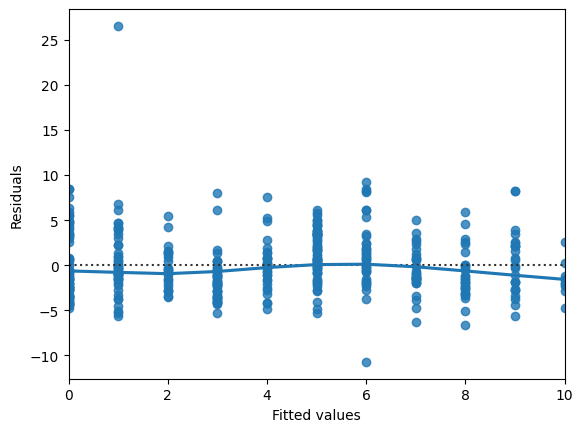

In [16]:
# plot residuals vs fitted values of Taiwan real estate
sns.residplot(
    taiwan_real_estate,
    x="n_convenience",
    y="price_twd_msq",
    lowess=True,
)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

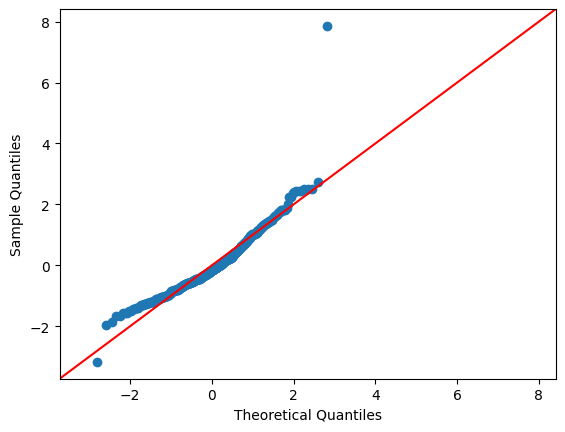

In [17]:
# qqplot
qqplot(mdl_price_vs_conv.resid, fit=True, line="45")
plt.show()

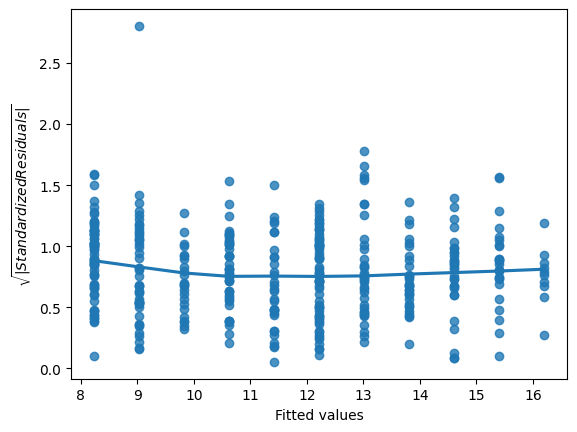

In [18]:
model_norm_residuals = mdl_price_vs_conv.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# scale-location plot
sns.regplot(
    x=mdl_price_vs_conv.fittedvalues,
    y=model_norm_residuals_abs_sqrt,
    lowess=True,
    ci=None,
)
plt.xlabel("Fitted values")
plt.ylabel("$\sqrt{|Standardized Residuals|}$")
plt.show()

### Outliers

_Outliers_ are points that deviate significantly from the overall pattern of the data.

_Leverage_ measures how far an observation is from the center of the explanatory variable values. Points with high leverage can have a large effect on the regression line and thus the fit of the model.

_Influence_ combines outliers and leverage to measure how much a single observation affects the fitted model.

Statsmodels models have a `get_influence()` method that returns an object with a `summary_frame()` method that returns a DataFrame with information about each observation. In particular, the `hat_diag` column contains the leverage values for each observation and the `cooks_d` column contains the influence values as measured by _Cook's Distance_, which calculates the effect of removing each observation on the fitted model.

In [19]:
summary_info = mdl_price_vs_dist.get_influence().summary_frame()

taiwan_real_estate["hat_diag"] = summary_info["hat_diag"]
taiwan_real_estate["cooks_d"] = summary_info["cooks_d"]

print(taiwan_real_estate.sort_values("hat_diag", ascending=False).head())
print(taiwan_real_estate.sort_values("cooks_d", ascending=False).head())

     dist_to_mrt_m  n_convenience house_age_years  price_twd_msq  \
347       6488.021              1        15 to 30       3.388805   
116       6396.283              1        30 to 45       3.691377   
249       6306.153              1        15 to 30       4.538578   
255       5512.038              1        30 to 45       5.264750   
8         5512.038              1        30 to 45       5.688351   

     sqrt_dist_to_mrt_m  hat_diag   cooks_d  
347           80.548253  0.026665  0.003508  
116           79.976765  0.026135  0.004470  
249           79.411290  0.025617  0.009373  
255           74.243101  0.021142  0.006304  
8             74.243101  0.021142  0.009060  
     dist_to_mrt_m  n_convenience house_age_years  price_twd_msq  \
270       252.5822              1         0 to 15      35.552194   
148      3780.5900              0        15 to 30      13.645991   
228      3171.3290              0         0 to 15      14.099849   
220       186.5101              9        30

## Logistic Regression

When the response variable is _logical_ (binary), all points lie on the $y = 0$ or $y = 1$ line. In this case, linear regression is not appropriate. Instead, you can use _logistic regression_.


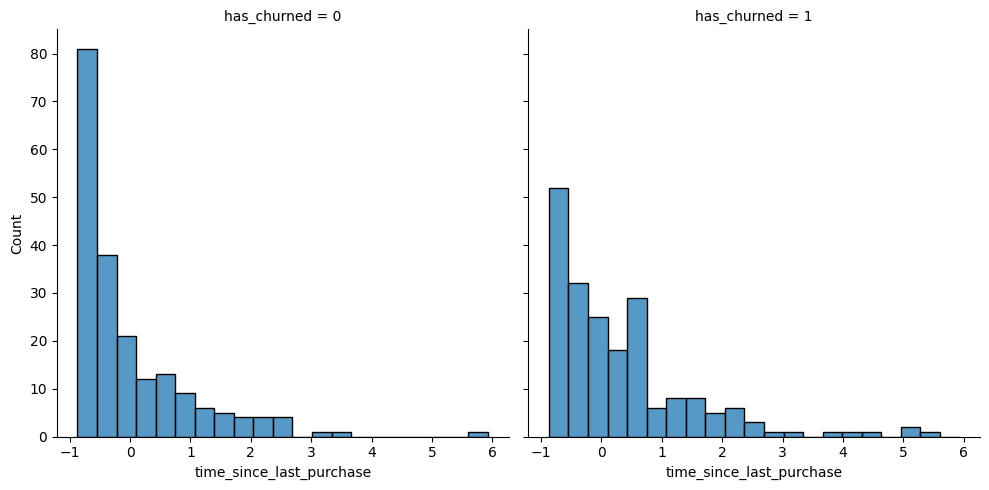

In [20]:
# hist plot `time_since_last_purchase` split by `has_churned`
sns.displot(churn, x="time_since_last_purchase", col="has_churned")
plt.show()

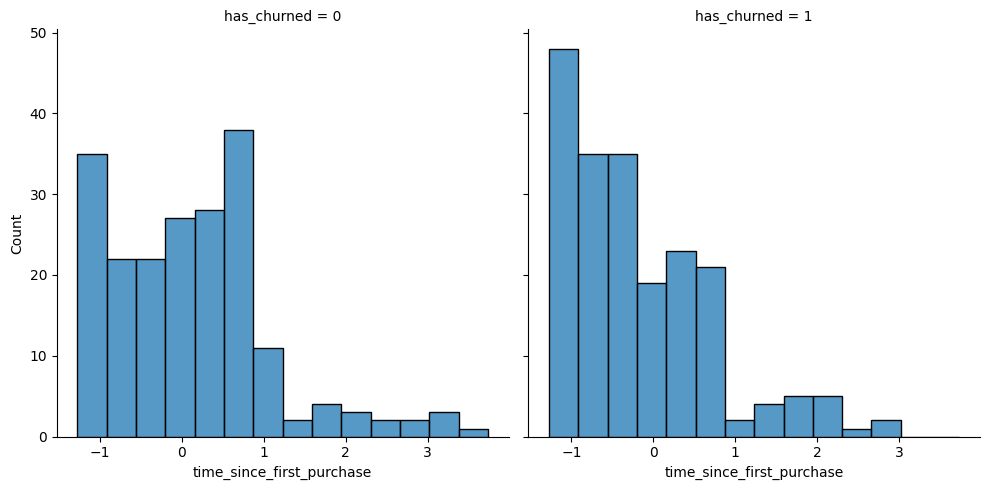

In [21]:
sns.displot(churn, x="time_since_first_purchase", col="has_churned")
plt.show()

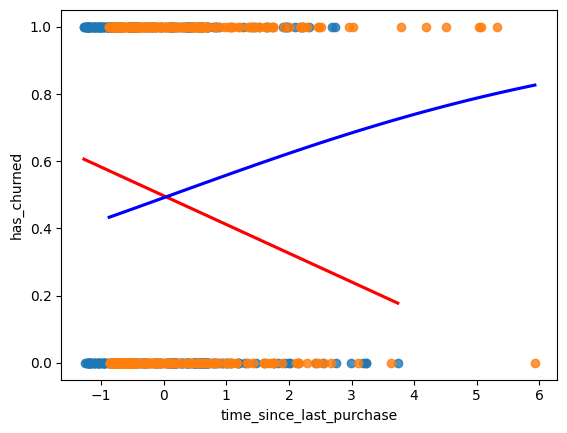

In [22]:
# reg plot `time_since_first_purchase` vs `has_churned`
sns.regplot(
    churn, x="time_since_first_purchase", y="has_churned", ci=None, line_kws={"color": "red"}
)
sns.regplot(
    churn,
    x="time_since_last_purchase",
    y="has_churned",
    ci=None,
    logistic=True,
    line_kws={"color": "blue"},
)
plt.show()

In [23]:
# fit logistic regression of churn vs length of relationship
mdl_churn_vs_relationship = logit("has_churned ~ time_since_first_purchase", data=churn).fit()
print(mdl_churn_vs_relationship.params)

Optimization terminated successfully.
         Current function value: 0.679663
         Iterations 4
Intercept                   -0.015185
time_since_first_purchase   -0.354795
dtype: float64


### Odds Ratio

An _odds ratio_ compares the probability of something happening to the probability of it not happening. If a customer has a 20% probability of churning, then they have an 80% probability of not churning. It may be more intuitive to say "they are 4 times more likely to not churn than to churn".

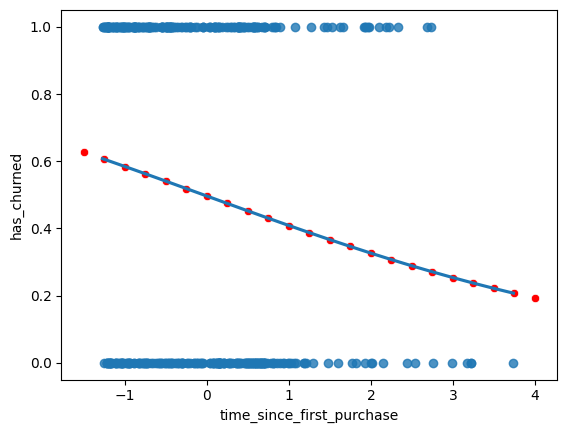

In [24]:
# `time_since_first_purchase` is "a range" from -1.5 to 4.0
explanatory_data = pd.DataFrame({"time_since_first_purchase": np.arange(-1.5, 4.25, 0.25)})
prediction_data = explanatory_data.assign(
    has_churned=mdl_churn_vs_relationship.predict(explanatory_data)
)

# plot
fig = plt.figure()
sns.regplot(
    churn,
    x="time_since_first_purchase",
    y="has_churned",
    ci=None,
    logistic=True,
)
sns.scatterplot(prediction_data, x="time_since_first_purchase", y="has_churned", color="red")
plt.show()

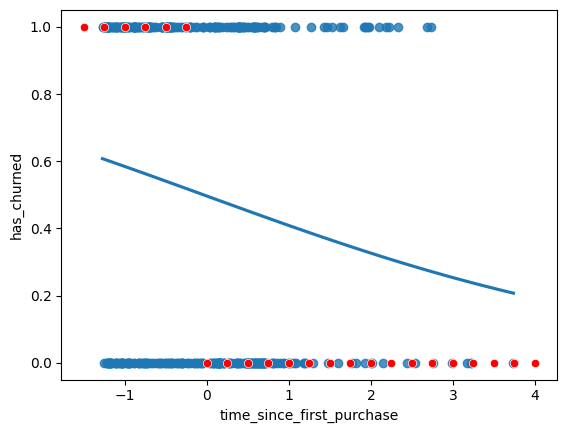

In [25]:
prediction_data["most_likely_outcome"] = prediction_data.has_churned.round()

# plot
fig = plt.figure()
sns.regplot(
    churn,
    x="time_since_first_purchase",
    y="has_churned",
    ci=None,
    logistic=True,
)
sns.scatterplot(
    prediction_data, x="time_since_first_purchase", y="most_likely_outcome", color="red"
)
plt.show()

   time_since_first_purchase  has_churned  most_likely_outcome  odds_ratio
0                      -1.50     0.626448                  1.0    1.677003
1                      -1.25     0.605470                  1.0    1.534661
2                      -1.00     0.584096                  1.0    1.404400
3                      -0.75     0.562401                  1.0    1.285197
4                      -0.50     0.540465                  1.0    1.176111


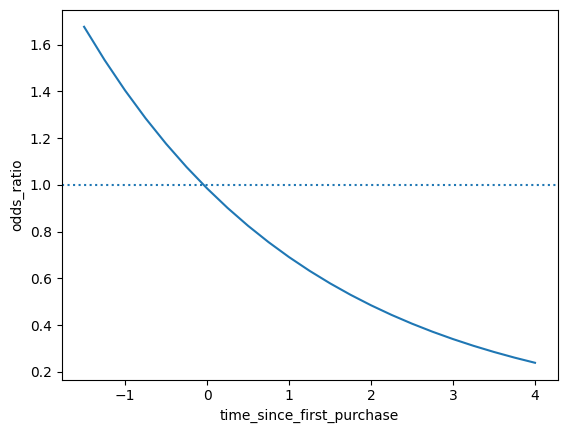

In [26]:
prediction_data["odds_ratio"] = prediction_data.has_churned / (1 - prediction_data.has_churned)
print(prediction_data.head())

fig = plt.figure()
sns.lineplot(
    prediction_data,
    x="time_since_first_purchase",
    y="odds_ratio",
    errorbar=None,
)
# Add a dotted horizontal line at odds_ratio = 1
plt.axhline(y=1, linestyle="dotted")
plt.show()

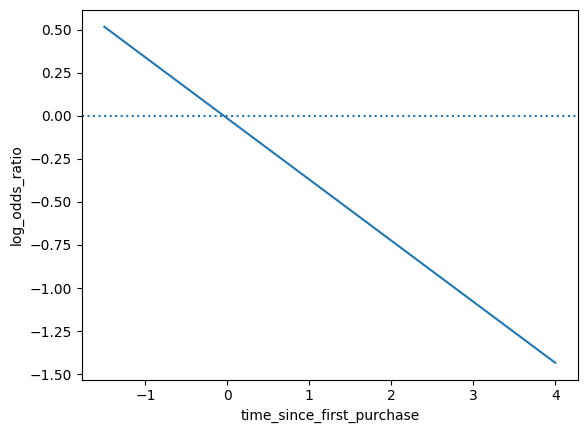

In [27]:
# update `prediction_data` with log_odds_ratio
prediction_data["log_odds_ratio"] = np.log(prediction_data.odds_ratio)

fig = plt.figure()
sns.lineplot(
    prediction_data,
    x="time_since_first_purchase",
    y="log_odds_ratio",
    errorbar=None,
)
plt.axhline(y=0, linestyle="dotted")
plt.show()

### Confusion Matrices

A _confusion matrix_ is the basis of all performance metrics for models with a categorical response (such as a logistic regression). It contains the counts of each response-predicted pair.

When dealing with _binary_ responses, there are four possible outcomes:
  * true positive (TP) - predicted that they churned and they did
  * true negative (TN) - predicted that they didn't churn and they didn't
  * false positive (FP) - predicted that they churned but they didn't
  * false negative (FN) - predicted that they didn't churn but they did

We can measure the performance of a model using _accuracy_, _sensitivity_, and _specificity_.

$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

The proportion of correct predictions.

$\text{Sensitivity} = \frac{TP}{TP + FN}$

The proportion of correct positive predictions aka recall or true positive rate.

$\text{Specificity} = \frac{TN}{TN + FP}$

The proportion of correct negative predictions aka true negative rate.

In [28]:
actual_response = churn.has_churned
predicted_response = np.round(mdl_churn_vs_relationship.predict(churn))
outcomes = pd.DataFrame(
    {"actual_response": actual_response, "predicted_response": predicted_response.round()}
)
print(outcomes.value_counts(sort=False))

actual_response  predicted_response
0                0.0                   112
                 1.0                    88
1                0.0                    76
                 1.0                   124
Name: count, dtype: int64


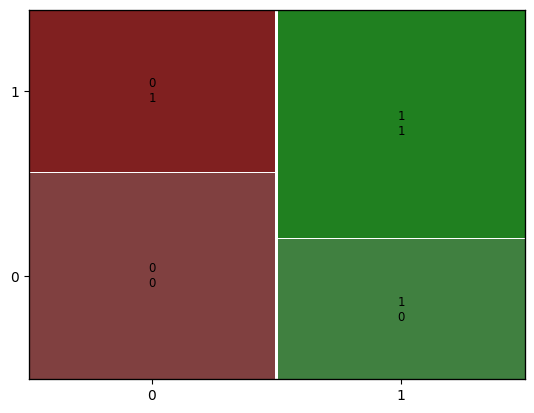

In [29]:
conf_matrix = mdl_churn_vs_relationship.pred_table()
mosaic(conf_matrix)
plt.show()

In [30]:
TN = conf_matrix[0][0]
TP = conf_matrix[1][1]
FN = conf_matrix[1][0]
FP = conf_matrix[0][1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"accuracy: {accuracy}")
print(f"sensitivity: {sensitivity}")
print(f"specificity: {specificity}")

accuracy: 0.59
sensitivity: 0.62
specificity: 0.56
